# Chapter 9 Bayesian methods
## 9.3 Bayesian linear regression

In [10]:
import arviz as az
from bartz.BART import gbart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB

In [3]:
# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['R1M_Usd_C'] = (data_ml['R1M_Usd'] > 0).astype(int) # can be useful for classification tasks
data_ml.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd,R1M_Usd_C
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,...,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041,1
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,...,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253,1
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,...,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366,0
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376,1
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113,0


In [4]:
separation_date = pd.to_datetime('2013-01-01')
training_sample = data_ml.loc[data_ml['date'] < separation_date]
testing_sample = data_ml.loc[data_ml['date'] >= separation_date]
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]
predictors = ["Mkt_Cap_3M_Usd", "Pb"]

y_train = training_sample["R1M_Usd"].values
X_train = training_sample[predictors].values

In [6]:
with pm.Model() as model:
    # Priors
    intercept = pm.Normal("intercept", mu=0.0, sigma=1.0)
    beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=len(predictors))
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Deterministic calculation for the mean
    mu = intercept + pm.math.dot(X_train, beta)
    
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    # SAMPLING: Using the JAX-based NumPyro sampler to avoid C++ requirements
    # This will compile using JAX/XLA instead of g++
    idata = pm.sample(
        draws=1000, 
        tune=1000, 
        target_accept=0.9, 
        random_seed=42,
        nuts_sampler="numpyro"
    )

# 3. Analyze results
summary = az.summary(idata, var_names=["intercept", "beta", "sigma"])
print(summary)

d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 0:   5%|▌         | 100/2000 [00:03<00:32, 59.33it/s]


Running chain 0:  10%|█         | 200/2000 [00:08<01:01, 29.08it/s]




Running chain 0:  15%|█▌        | 300/2000 [00:11<00:56, 30.34it/s]


Running chain 0:  20%|██        | 400/2000 [00:13<00:46, 34.38it/s]


Running chain 0:  25%|██▌       | 500/2000 [00:15<00:40, 37.10it/s]


Running chain 0:  30%|███       | 600/2000 [00:18<00:35, 39.18it/s]


Running chain 0:  35%|███▌      | 700/2000 [00:20<00:32, 40.44it/s]


Running chain 0:  40%|████      | 800/2000 [00:22<00:28, 42.10it/s]


Running chain 0:  45%|████▌     | 900/2000 [00:24<00:24, 

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.030  0.001   0.028    0.032        0.0      0.0    2689.0   
beta[0]   -0.022  0.001  -0.025   -0.020        0.0      0.0    2094.0   
beta[1]   -0.011  0.001  -0.014   -0.009        0.0      0.0    2038.0   
sigma      0.175  0.000   0.174    0.175        0.0      0.0    2410.0   

           ess_tail  r_hat  
intercept    2447.0    1.0  
beta[0]      2071.0    1.0  
beta[1]      1948.0    1.0  
sigma        2457.0    1.0  


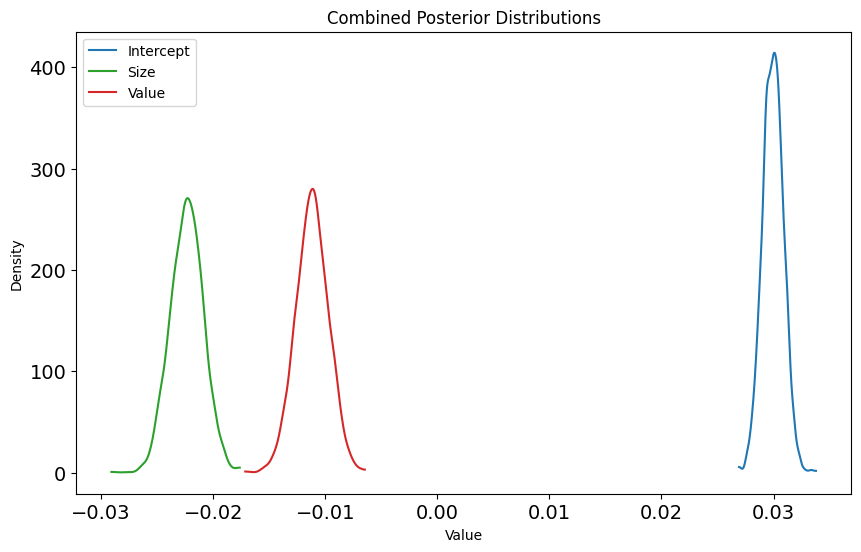

In [7]:
# Create a single figure
plt.figure(figsize=(10, 6))

# Plot each variable onto the same axis (gca = get current axis)
az.plot_dist(idata.posterior["intercept"], label="Intercept", color="C0")

# Extract specific beta dimensions for Size and Value
size_dist = idata.posterior["beta"].sel(beta_dim_0=0)
value_dist = idata.posterior["beta"].sel(beta_dim_0=1)

az.plot_dist(size_dist, label="Size", color="C2")
az.plot_dist(value_dist, label="Value", color="C3")

plt.title("Combined Posterior Distributions")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

## 9.4 Naive Bayes classifier

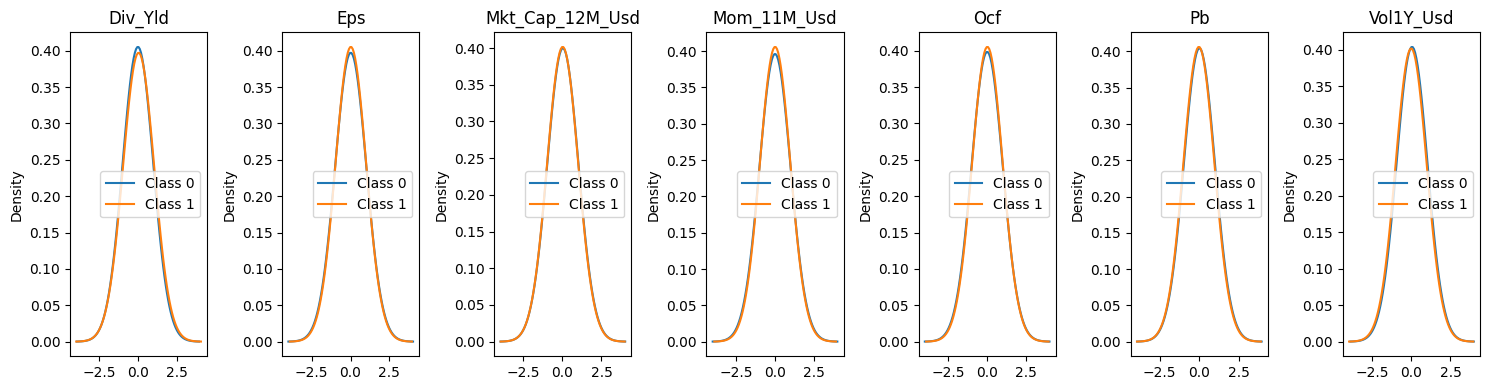

In [8]:
# Build sample - transform features
gauss_features_train = training_sample[features_short].values
gauss_features_train = np.clip(gauss_features_train * 0.999 + 0.0001, 0.0001, 0.9999)  # Keep between 0 and 1
gauss_features_train = norm.ppf(gauss_features_train)  # Inverse Gaussian CDF

# Fit Gaussian Naive Bayes
fit_NB_gauss = GaussianNB()
fit_NB_gauss.fit(gauss_features_train, training_sample["R1M_Usd_C"].values)

# Plot conditional probabilities
fig, axes = plt.subplots(1, len(features_short), figsize=(15, 4))
for i, feature in enumerate(features_short):
    ax = axes[i]
    for j, class_val in enumerate([0, 1]):
        mean = fit_NB_gauss.theta_[class_val, i]
        var = fit_NB_gauss.var_[class_val, i]
        x = np.linspace(mean - 4*np.sqrt(var), mean + 4*np.sqrt(var), 100)
        y = norm.pdf(x, mean, np.sqrt(var))
        ax.plot(x, y, label=f"Class {class_val}")
    ax.set_title(f"{feature}")
    ax.set_ylabel("Density")
    ax.legend()
plt.tight_layout()
plt.show()


In [9]:
# Build test sample - transform features
gauss_features_test = testing_sample[features_short].values
gauss_features_test = np.clip(gauss_features_test * 0.999 + 0.0001, 0.0001, 0.9999)  # Keep between 0 and 1
gauss_features_test = norm.ppf(gauss_features_test)  # Inverse Gaussian CDF

# Make predictions and calculate hit ratio
predictions = fit_NB_gauss.predict(gauss_features_test)
hit_ratio = np.mean(predictions == testing_sample["R1M_Usd_C"].values)
print(f"Hit ratio: {hit_ratio:.4f}")


Hit ratio: 0.5557


## 9.5 Bayesian additive trees

In [12]:
# 1. Data Setup - TRANSPOSE X here
# bartz expects shape (features, observations)
X_train = training_sample[features_short].values.astype(np.float32).T 
y_train = training_sample['R1M_Usd'].values.astype(np.float32)
X_test = testing_sample[features_short].values.astype(np.float32).T

# 2. Initialize and Run 
model = gbart(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    ntree=20,       
    ndpost=200,     
    nskip=100,      
    base=0.95,      
    power=2.0       
)

# 3. Predict
# model.yhat_test shape will be (ndpost, n_test_observations)
y_hat = np.mean(model.yhat_test, axis=0)

....................................................................................................
It 100/300 grow P=65% A=0%, prune P=35% A=0%, fill=7% (burnin)
....................................................................................................
It 200/300 grow P=70% A=0%, prune P=30% A=0%, fill=9%
....................................................................................................
It 300/300 grow P=65% A=0%, prune P=35% A=0%, fill=10%


In [13]:
# Compute BART hit ratio (sign accuracy)
y_test = testing_sample["R1M_Usd"].values.astype(np.float32)
hit_ratio_bart = np.mean((y_hat * y_test) > 0)
print(f"BART hit ratio: {hit_ratio_bart:.4f}")


BART hit ratio: 0.5548


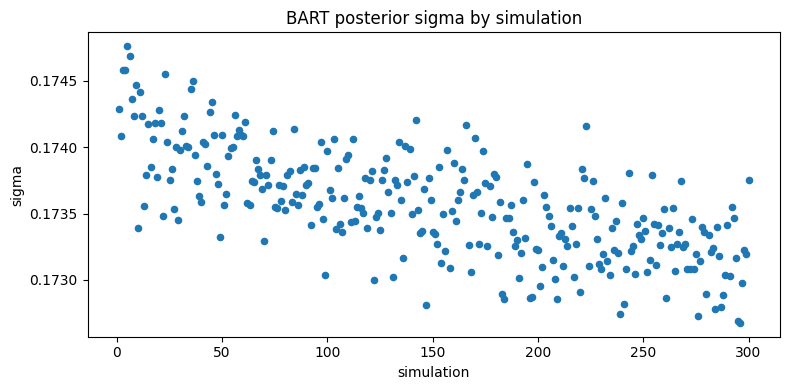

In [14]:
# Plot posterior sigma chain across simulations
sigma_chain = np.asarray(model.sigma).ravel()
sim = np.arange(1, sigma_chain.shape[0] + 1)
plt.figure(figsize=(8, 4))
plt.scatter(sim, sigma_chain, s=20)
plt.xlabel("simulation")
plt.ylabel("sigma")
plt.title("BART posterior sigma by simulation")
plt.tight_layout()
plt.show()
